In [3]:
%matplotlib inline
import os
import re
import string

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

In [4]:
from IPython.core.display import display, HTML

def display_side_by_side(dfs:list, captions:list):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += "\xa0\xa0\xa0"
    display(HTML(output))

In [5]:
def is_binary(series, allow_na=False):
    if allow_na:
        series.dropna(inplace=True)
    return sorted(series.unique()) == [0, 1]

In [6]:
master = pd.read_pickle("enron_random_clean1_senders.pkl")

In [8]:
master.dtypes

line                object
filename            object
entity              object
len                  int64
lineNo               int64
                     ...  
next_same_entity     int64
sender              object
sender_name         object
has_sender            bool
has_sender_name      int64
Length: 69, dtype: object

# Note: Consider adding quantile for the position of the line.

Meaning in which quantile of the message is the line

In [315]:
master.loc[150:165:,("line", "posFromEnd", "last", "prevlast", "last5", "last11", "posRatio", "posRatioNB", "len", "len_avg", "lenRatio")]

,line,posFromEnd,last,prevlast,last5,last11,posRatio,posRatioNB,len,len_avg,lenRatio
150,Yes there are many different subs that have be...,9,0,0,0,1,0.943750,1.086331,69,53.0,1.301887
151,provide these if you are interested.,8,0,0,0,1,0.950000,1.093525,36,53.0,0.679245
152,,7,0,0,0,1,0.956250,1.100719,0,53.0,0.000000
153,"I know I have not answered everything, but thi...",6,0,0,0,1,0.962500,1.107914,74,53.0,1.396226
154,when you have reviewed and we can discuss furt...,5,0,0,0,1,0.968750,1.115108,50,53.0,0.943396
155,,4,0,0,1,1,0.975000,1.122302,0,53.0,0.000000
156,"Sincerely,",3,0,0,1,1,0.981250,1.129496,10,53.0,0.188679
157,,2,0,0,1,1,0.987500,1.136691,0,53.0,0.000000
158,George Richards,1,0,1,1,1,0.993750,1.143885,15,53.0,0.283019
159,"President, Creekside Builders, LLC",0,1,0,1,1,1.000000,1.151079,34,53.0,0.641509


In [316]:
master.sample(10).loc[:,("len", "len_avg", "less_avg_len", "more_avg_len", "line", "hasCid")]

G:\Programs\Anaconda2\envs\thesis-enron\lib\site-packages\pandas\core\indexing.py:805: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_lowerdim(tup)


,len,len_avg,less_avg_len,more_avg_len,line,hasCid
3571,27,30.0,1,0,-----Original Message-----,NaN
727,27,31.0,1,0,Outlook 2000 Migration Team,NaN
7272,77,31.0,0,1,"telecommunications, network, and entertainment...",NaN
10757,75,29.0,0,1,"Feel free to copy all you want, assuming there...",NaN
9341,0,43.0,1,0,,NaN
5978,0,15.0,1,0,,NaN
3535,70,38.0,0,1,the original one used by Enron and edited acco...,NaN
3740,76,35.0,0,1,"will not see the final, calculated price until...",NaN
8008,0,20.0,1,0,,NaN
10014,28,29.0,1,0,> -----Original Message-----,NaN


In [317]:
all_features = feature_dict.keys() | ["last", "prevlast", "last5", "last11"]

In [318]:
signatures = master[master.entity == "signature"]

In [319]:
NOTsignatures = master[master.entity != "signature"]

In [320]:
len(signatures) + len(NOTsignatures)

18028

In [321]:
len(master)

18028

# What words are typical for signatures?

In [60]:
stop_words = "the and you to or of this for is in if are at by on it".split(" ")

In [63]:
from sklearn.feature_extraction.text import CountVectorizer
def get_top_n_words(corpus, n=None):
    """
    List the top n words in a vocabulary according to occurrence in a text corpus.
    
    get_top_n_words(["I love Python", "Python is a language programming", "Hello world", "I love the world"]) -> 
    [('python', 2),
     ('world', 2),
     ('love', 2),
     ('hello', 1),
     ('is', 1),
     ('programming', 1),
     ('the', 1),
     ('language', 1)]
    """
#     vec = CountVectorizer(stop_words=stop_words).fit(corpus)
    vec = CountVectorizer(stop_words=stop_words).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [65]:
get_top_n_words(signatures.line, 30)

[('thanks', 109),
 ('com', 91),
 ('713', 90),
 ('enron', 51),
 ('fax', 48),
 ('regards', 33),
 ('http', 33),
 ('www', 33),
 ('your', 33),
 ('853', 30),
 ('thank', 27),
 ('email', 27),
 ('any', 26),
 ('phone', 26),
 ('texas', 23),
 ('mail', 22),
 ('corp', 21),
 ('646', 19),
 ('intended', 18),
 ('please', 18),
 ('best', 16),
 ('houston', 16),
 ('smith', 15),
 ('be', 15),
 ('mike', 15),
 ('77002', 15),
 ('sincerely', 14),
 ('inc', 14),
 ('use', 14),
 ('north', 14)]

In [66]:
get_top_n_words(NOTsignatures.line, 10)

[('enron', 1186),
 ('ect', 1128),
 ('that', 751),
 ('be', 700),
 ('will', 667),
 ('com', 630),
 ('with', 589),
 ('have', 574),
 ('hou', 571),
 ('we', 567)]

# 👉 More stop words in non-signatures

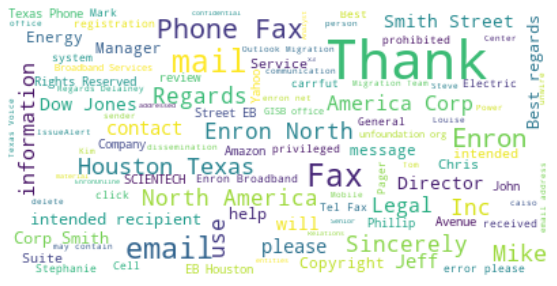

In [67]:
from wordcloud import WordCloud
# Generate a word cloud image
text = " ".join(signatures.line)
wordcloud = WordCloud().generate(text)

# lower max_font_size
wordcloud = WordCloud(max_font_size=40, max_words=100, background_color="white").generate(text)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


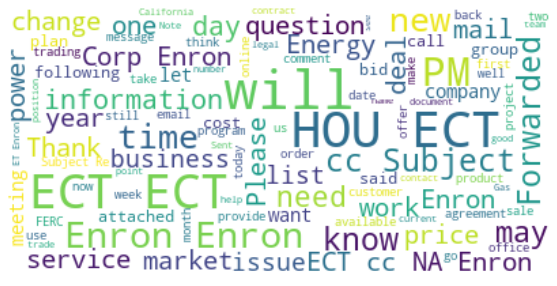

In [68]:
from wordcloud import WordCloud
# Generate a word cloud image
text = " ".join(NOTsignatures.line)
wordcloud = WordCloud().generate(text)

# lower max_font_size
wordcloud = WordCloud(max_font_size=40, max_words=100, background_color="white").generate(text)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


In [69]:
def get_unique_words(corpus):
    vec = CountVectorizer(stop_words=stop_words).fit(corpus)
    return set(vec.get_feature_names()) # probably set it not needed but just to be sure

# Find unique words for signatures

In [70]:
unique_sig_words = get_unique_words(signatures.line)
unique_non_sig_words = get_unique_words(NOTsignatures.line)

In [71]:
print(f"Unique words in signatures: {len(unique_sig_words)}")
print(f"Unique words in NOT signatures: {len(unique_non_sig_words)}")

Unique words in signatures: 1474
Unique words in NOT signatures: 11242


In [72]:
unique_only_in_sig = [w for w in unique_sig_words if w not in unique_non_sig_words and not w.isdigit()]

In [73]:
print(f"Unique words ONLY in signatures: {len(unique_only_in_sig)}")

Unique words ONLY in signatures: 214


In [74]:
get_top_n_words(unique_only_in_sig, 10)

[('thereto', 1),
 ('beijos', 1),
 ('duhon', 1),
 ('lcampbel', 1),
 ('mheffner', 1),
 ('trammell', 1),
 ('retransmission', 1),
 ('vkaminski', 1),
 ('tel', 1),
 ('para', 1)]

***👉 There are no good unique only to the signatures words, most are names and addresses***

# How often there are digits in signatures vs the rest?

In [75]:
print(f"Digits in signatures: {len([w for w in unique_sig_words if w.isdigit()])}")
print(f"Digits in signatures: {len([w for w in unique_non_sig_words if w.isdigit()])}")

Digits in signatures: 303
Digits in signatures: 649


In [76]:
# maybe parts of phone numbers are longer digits?
print(f"Digits in signatures: {len([w for w in unique_sig_words if w.isdigit() and len(w) > 3])}")
print(f"Digits in signatures: {len([w for w in unique_non_sig_words if w.isdigit() and len(w) > 3])}")

Digits in signatures: 174
Digits in signatures: 281


***👉 There are more digits unique to non-signatures but they are also much more data, not helpful***

# Where are the signatures in the text?

In [77]:
# Median file length
print(f"Median file length: {np.median(df_files.nlines)}")
print(f"Average file length: {np.mean(df_files.nlines)}")

Median file length: 21.5
Average file length: 34.93798449612403


In [78]:
df_files.nlines.quantile(np.arange(0, 1, .25))

0.00     1.0
0.25     9.0
0.50    21.5
0.75    42.0
Name: nlines, dtype: float64

In [79]:
df_files.nlines.quantile(np.arange(.5, 1, .05))  # 75% have under 100 lines

0.50     21.50
0.55     25.00
0.60     28.00
0.65     32.00
0.70     36.50
0.75     42.00
0.80     50.00
0.85     59.00
0.90     79.50
0.95    110.75
Name: nlines, dtype: float64

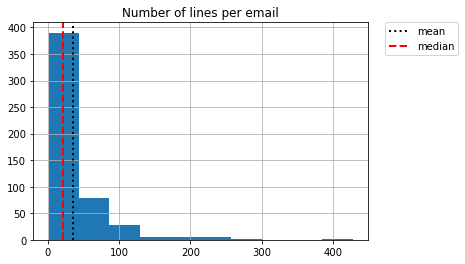

In [80]:
plt.hist(df_files.nlines)
plt.axvline(df_files.nlines.mean(), color='k', linestyle='dotted', linewidth=2, label="mean")
plt.axvline(df_files.nlines.median(), color='r', linestyle='dashed', linewidth=2, label="median")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title("Number of lines per email")
plt.grid()
plt.show()

In [81]:
min(df_files.nlines) # shortest email

1

In [82]:
len(df_files.loc[df_files.nlines==1,])

22

In [83]:
df_files.loc[df_files.nlines==1,]

,filename,nlines,len_avg,len_min,len_max,nBlanks,nNonBlanks,nSig
22,badeer-r_all_documents_280,1,16.0,16,16,0,1,0
29,bass-e_all_documents_1106,1,27.0,27,27,0,1,0
59,buy-r_all_documents_103,1,36.0,36,36,0,1,0
61,buy-r_all_documents_142,1,21.0,21,21,0,1,0
103,derrick-j_all_documents_15,1,60.0,60,60,0,1,0
124,farmer-d_all_documents_4852,1,32.0,32,32,0,1,0
141,gay-r_all_documents_383,1,63.0,63,63,0,1,0
153,gilbertsmith-d_all_documents_95,1,67.0,67,67,0,1,0
201,hendrickson-s_all_documents_38,1,54.0,54,54,0,1,0
219,hyvl-d_all_documents_1531,1,54.0,54,54,0,1,0


In [84]:
max(df_files.nlines) # longest email

428

In [85]:
len(df_files.loc[df_files.nlines>100,])

34

In [86]:
master.loc[master.nlines>200,["line", "filename", "entity", "len", "nlines"]]

,line,filename,entity,len,nlines
4187,"Great--Steve, what's your phone no. ? The ope...",fossum-d_all_documents_1110,no_entity,75,226
4188,like to talk for a few minutes on this. Thank...,fossum-d_all_documents_1110,no_entity,51,226
4189,,fossum-d_all_documents_1110,no_entity,0,226
4190,,fossum-d_all_documents_1110,no_entity,0,226
4191,,fossum-d_all_documents_1110,no_entity,0,226
...,...,...,...,...,...
17643,>,wheldon-c_all_documents_163,signature,1,263
17644,> Sandra Vizzacchero Goldman,wheldon-c_all_documents_163,signature,46,263
17645,> Executive Assistant to Avi Nash Sachs,wheldon-c_all_documents_163,signature,44,263
17646,> Chemicals Equity Research Team,wheldon-c_all_documents_163,signature,32,263


In [87]:
# Signature length in number of lines
print(f"Median signature length: {master.nSig.median()} lines")
print(f"Mean signature length: {master.nSig.mean()} lines")

Median signature length: 3.0 lines
Mean signature length: 5.159973374750388 lines


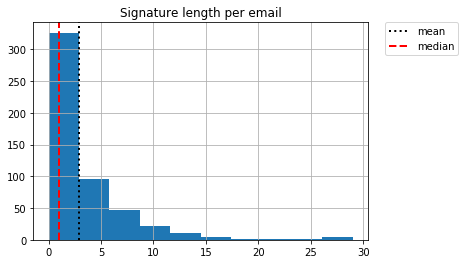

In [88]:
plt.hist(df_files.nSig)
plt.axvline(df_files.nSig.mean(), color='k', linestyle='dotted', linewidth=2, label="mean")
plt.axvline(df_files.nSig.median(), color='r', linestyle='dashed', linewidth=2, label="median")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title("Signature length per email")
plt.grid()
plt.show()

In [89]:
nsig_to_nlines = df_files.nSig / df_files.nlines

In [90]:
nsig_to_nlines.mean()*100

12.4795221710836

In [91]:
master.nSig.median() / master.nlines.median() # the median signature is 15% of the median file (all lines)

0.05084745762711865

In [92]:
master.nSig.median() / master.nNonBlanks.median() # the median signature is 44% of the median file (non-blank lines)

0.06976744186046512

In [93]:
noreplies = master[~master.line.str.startswith(">")]

In [94]:
# Median file length without replies
print(f"Median file length: {np.median(noreplies.nNonBlanks)}")
print(f"Average file length: {np.mean(noreplies.nNonBlanks)}")

Median file length: 41.0
Average file length: 67.63655876551805


In [95]:
# Line No of signatures
print(f"Median lineNo: {np.median(signatures.lineNo)}")
print(f"Average lineNo: {np.mean(signatures.lineNo)}")

Median lineNo: 25.0
Average lineNo: 44.42007926023778


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002923772A488>]],
      dtype=object)

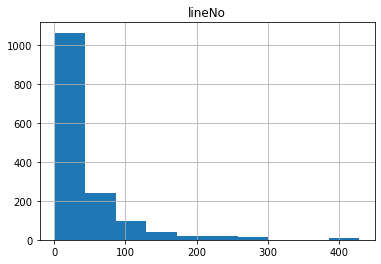

In [96]:
signatures.hist(column="lineNo")

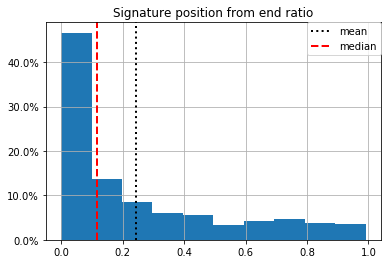

In [97]:
ax = plt.gca()
ax.yaxis.set_major_formatter(PercentFormatter(xmax=1))
#plt.ylim(top=1)
plt.hist(signatures.posRatioFromEnd, weights=np.ones(len(signatures)) / len(signatures))
#plt.hist(signatures.posRatioFromEnd)
plt.axvline(signatures.posRatioFromEnd.mean(), color='k', linestyle='dotted', linewidth=2, label="mean")
plt.axvline(signatures.posRatioFromEnd.median(), color='r', linestyle='dashed', linewidth=2, label="median")
plt.legend(loc='best', borderaxespad=0.)
plt.title("Signature position from end ratio")
plt.grid()
plt.show()

In [98]:
print(f"Mean signatures.posRatioFromEnd: {signatures.posRatioFromEnd.mean()}")
print(f"Median signatures.posRatioFromEnd: {signatures.posRatioFromEnd.median()}")

Mean signatures.posRatioFromEnd: 0.2433559928124494
Median signatures.posRatioFromEnd: 0.11620294599018004


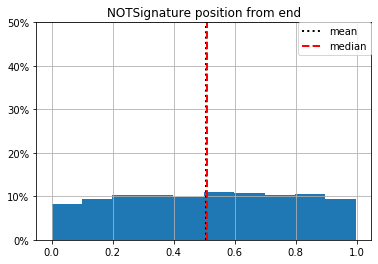

In [99]:
ax = plt.gca()
ax.yaxis.set_major_formatter(PercentFormatter(xmax=1))
plt.ylim(top=.5)
plt.hist(NOTsignatures.posRatioFromEnd, weights=np.ones(len(NOTsignatures)) / len(NOTsignatures))
# plt.hist(NOTsignatures.posRatioFromEnd)
plt.axvline(NOTsignatures.posRatioFromEnd.mean(), color='k', linestyle='dotted', linewidth=2, label="mean")
plt.axvline(NOTsignatures.posRatioFromEnd.median(), color='r', linestyle='dashed', linewidth=2, label="median")
plt.legend(loc='best', borderaxespad=0.)
plt.title("NOTSignature position from end")
plt.grid()
plt.show()

In [100]:
signatures.posFromEnd.quantile(np.arange(.5, 1, .05))

0.50     4.0
0.55     5.0
0.60     6.0
0.65     8.0
0.70    11.0
0.75    16.0
0.80    22.0
0.85    30.0
0.90    45.0
0.95    74.0
Name: posFromEnd, dtype: float64

In [101]:
NOTsignatures.posFromEnd.quantile(np.arange(0, 1, .05))

0.00      0.0
0.05      2.0
0.10      5.0
0.15      7.0
0.20      9.0
0.25     12.0
0.30     14.0
0.35     17.0
0.40     20.0
0.45     23.0
0.50     27.0
0.55     32.0
0.60     37.0
0.65     43.0
0.70     51.0
0.75     61.0
0.80     74.0
0.85     91.0
0.90    118.0
0.95    166.0
Name: posFromEnd, dtype: float64

# How much can be explained only from posFromEnd?

In [102]:
# label encoding
master["entity"] = master["entity"].astype('category')
master["entity_code"] = master["entity"].cat.codes

In [103]:
master.loc[:, ["entity", "entity_code", "entity_code_reversed"]]

G:\Programs\Anaconda2\envs\thesis-enron\lib\site-packages\pandas\core\indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


,entity,entity_code,entity_code_reversed
0,no_entity,0,NaN
1,no_entity,0,NaN
2,no_entity,0,NaN
3,no_entity,0,NaN
4,no_entity,0,NaN
...,...,...,...
18023,no_entity,0,NaN
18024,no_entity,0,NaN
18025,signature,1,NaN
18026,signature,1,NaN


In [104]:
from sklearn.linear_model import LogisticRegression
X, y = master.posFromEnd.values.reshape(-1, 1), master.entity_code
clf = LogisticRegression(random_state=0, solver='liblinear').fit(X, y)

In [105]:
clf.classes_

array([0, 1], dtype=int8)

In [106]:
[a[0]*100 for a in clf.coef_] 
# [-13.458100885847173] - 
# negative coefficient, negative relationsip, 
# the bigger the number, the less likely is to be a signature

[-2.937060683183243]

In [107]:
from scipy import stats
stats.pointbiserialr(master.posFromEnd, master.entity_code)

PointbiserialrResult(correlation=-0.1510998686686445, pvalue=1.5479124309391808e-92)

In [108]:
from sklearn.linear_model import LogisticRegression
X, y = master.posRatio.values.reshape(-1, 1), master.entity_code
clf = LogisticRegression(random_state=0, solver='liblinear').fit(X, y)

In [109]:
clf.coef_

array([[3.70245202]])

In [110]:
from scipy import stats
stats.pointbiserialr(master.posRatio, master.entity_code)

PointbiserialrResult(correlation=0.2536040593564517, pvalue=1.4490753954956535e-262)

# Point biserial vs Logistic Regression
All three procedures can yield, if this is of interest, p-values telling the probability that results as far or farther from the usual null hypothesis would occur if chance alone were responsible. Beyond that, each procedure will give a different type of potentially useful information:

* Point-biserial correlation will yield a coefficient ranging from -1 to 1, summarizing (in somewhat abstract or scale-free terms) the degree of connection between age and smoking status. (Note that the lesser-used "biserial correlation" works somewhat differently: see explanation).
* T-testing will describe the mean age difference between smokers and non-smokers in terms of the standard error of such a difference.
* Logistic regression will yield the difference in (the odds of being a smoker) that is associated with each unit (presumably year) difference in age. Logistic regression can also be used to generate a probability that each person is a smoker, based on age.

Thus in a given research situation these procedures may well turn out to be complementary.
https://stats.stackexchange.com/questions/189234/which-is-better-how-they-differ-independent-t-test-or-simple-logistic-regressio

https://www.displayr.com/how-to-interpret-logistic-regression-coefficients/

# Relationships between continuous and categorical variables
One useful way to explore the relationship between a continuous and a categorical variable is with a set of side by side box plots, one for each of the categories. Similarities and differences between the category levels can be seen in the length and position of the boxes and whiskers.

https://www.ssc.wisc.edu/sscc/pubs/DWE/book/3-3-sect-ggplot-categorical.html

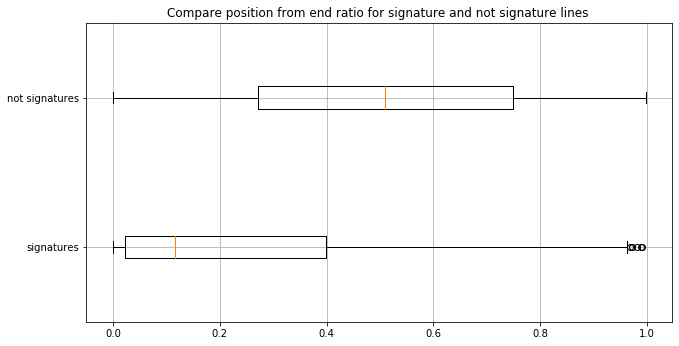

In [322]:
plt.boxplot([signatures.posRatioFromEnd, NOTsignatures.posRatioFromEnd], vert=False, labels=["signatures", "not signatures"])
plt.title("Compare position from end ratio for signature and not signature lines ")
fig = plt.gcf()
fig.set_size_inches(10.5, 5.5)
plt.grid()
plt.show()

(array([1344., 1565., 1689., 1691., 1634., 1826., 1759., 1704., 1744.,
        1558.]),
 array([0.        , 0.09976636, 0.19953271, 0.29929907, 0.39906542,
        0.49883178, 0.59859813, 0.69836449, 0.79813084, 0.8978972 ,
        0.99766355]),
 <a list of 10 Patch objects>)

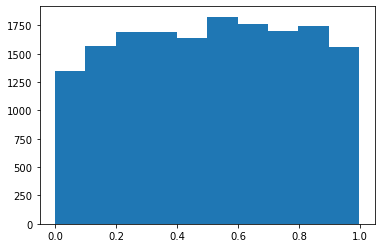

In [112]:
plt.hist(NOTsignatures.posRatioFromEnd)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000029237ECE488>]],
      dtype=object)

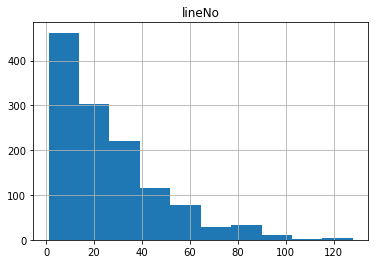

In [113]:
signatures[signatures.nlines-signatures.nBlanks < 75].hist(column="lineNo")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002923C281888>,
      dtype=object)

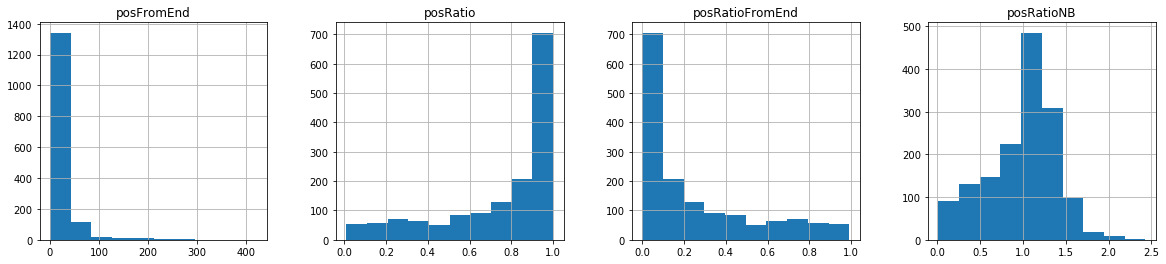

In [114]:
signatures.loc[:, ("posRatioNB", "posRatio", "posRatioFromEnd", "posFromEnd" )].hist(layout=(1,4), figsize=(20,4))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002923BE20148>,
      dtype=object)

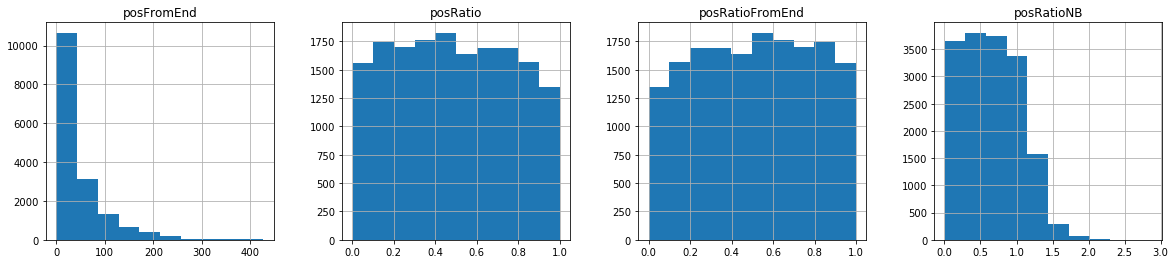

In [115]:
NOTsignatures.loc[:, ("posRatioNB", "posRatio", "posRatioFromEnd", "posFromEnd" )].hist(layout=(1,4), figsize=(20,4))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000029237F3B748>,
      dtype=object)

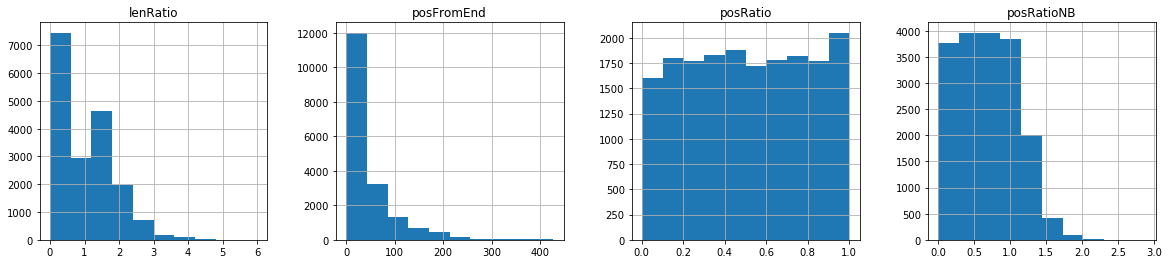

In [116]:
master.loc[:, ("posRatio", "posRatioNB", "posFromEnd", "lenRatio")].hist(layout=(1,4), figsize=(20,4))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002923C33F748>,
      dtype=object)

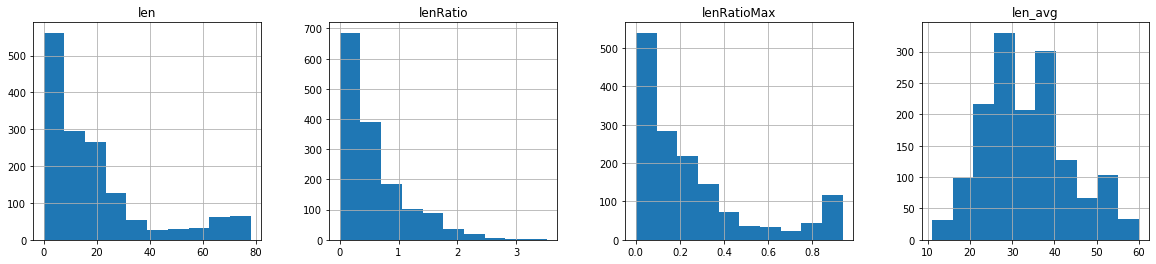

In [117]:
signatures.loc[:, ("len", "len_avg", "lenRatio", "lenRatioMax" )].hist(layout=(1,4), figsize=(20,4))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002923CB39AC8>,
      dtype=object)

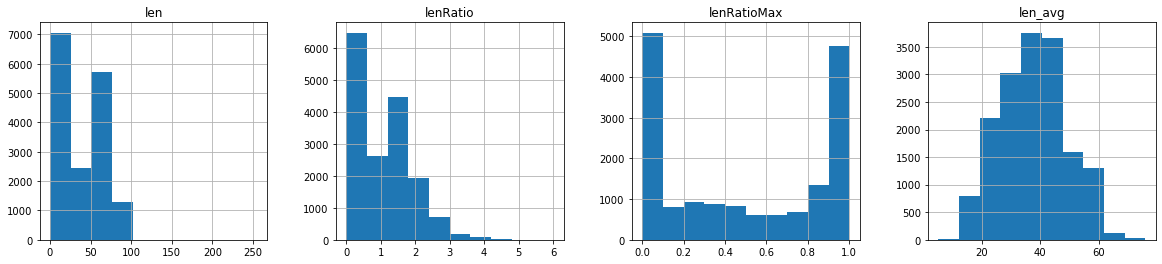

In [118]:
NOTsignatures.loc[:, ("len", "len_avg", "lenRatio", "lenRatioMax" )].hist(layout=(1,4), figsize=(20,4))

In [119]:
signatures.len.describe()

count    1514.000000
mean       18.953765
std        20.195554
min         0.000000
25%         5.000000
50%        13.000000
75%        24.000000
max        78.000000
Name: len, dtype: float64

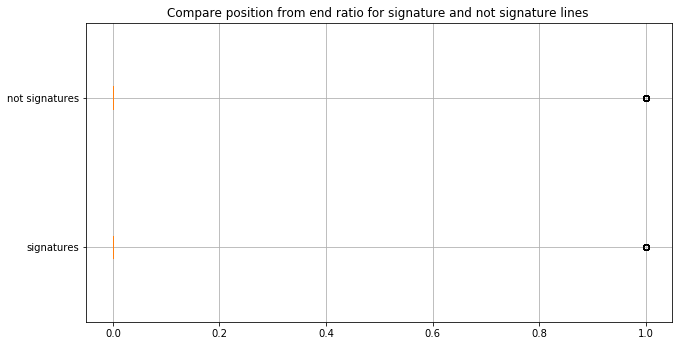

In [120]:
plt.boxplot([signatures.email, NOTsignatures.email], vert=False, labels=["signatures", "not signatures"])
plt.title("Compare position from end ratio for signature and not signature lines ")
fig = plt.gcf()
fig.set_size_inches(10.5, 5.5)
plt.grid()
plt.show()

In [121]:
def plot_stacked(columns):
    labels = [x for c in columns for x in [f"{c}_Sig", f"{c}_NOTSig"]]

    fig, ax = plt.subplots()
    plt.xticks(rotation=80)
    yes = list()
    no = list()

    for col in columns:
        all_sig = signatures.loc[:, col]
        yes_sig = signatures.loc[signatures[col] == 1, col]
        no_sig = signatures.loc[signatures[col] == 0, col]

        all_NOTsig = NOTsignatures.loc[:, col]
        yes_NOTsig = NOTsignatures.loc[NOTsignatures[col] == 1, col]
        no_NOTsig = NOTsignatures.loc[NOTsignatures[col] == 0, col]

        yes.extend([len(yes_sig)/len(all_sig), len(yes_NOTsig)/len(all_NOTsig)])
        no.extend([len(no_sig)/len(all_sig), len(no_NOTsig)/len(all_NOTsig)])


    ax.bar(labels, yes, 0.35, color="green")
    ax.bar(labels, no, 0.35, bottom=yes, color="orange")

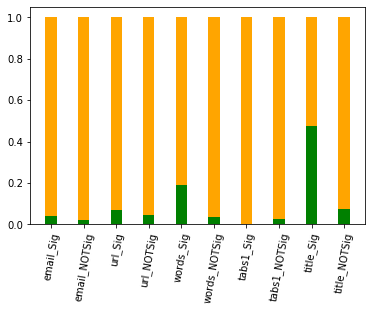

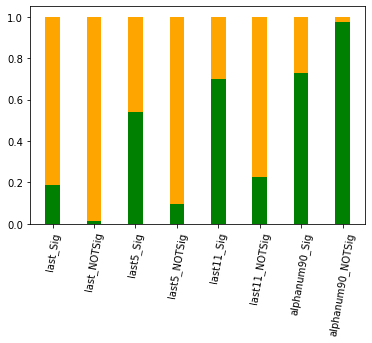

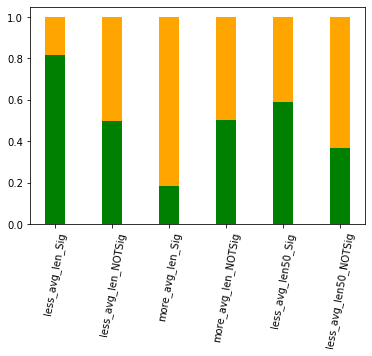

In [122]:
plot_stacked(["email", "url", "words", "tabs1", "title"])
plot_stacked(["last", "last5", "last11", "alphanum90"])
plot_stacked(["less_avg_len", "more_avg_len", "less_avg_len50"])

# Analyze num

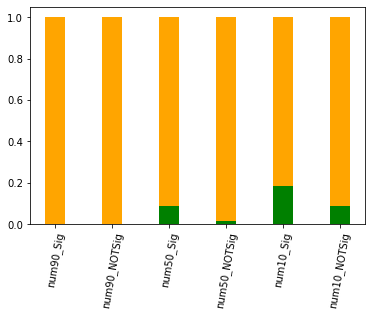

In [237]:
plot_stacked(["num90", "num50", "num10"])

In [269]:
entity_to_df = {
    "signature": signatures,
    "no_entity": NOTsignatures
}

In [238]:
num90 = master[master.num90 == 1]
num50 = master[master.num50 == 1]
num10 = master[master.num10 == 1]

In [286]:
from collections import Counter
entity_counts = Counter(num50.entity)
for entity in entity_to_df.keys():
    print(f"{(entity_counts[entity]/len(entity_to_df[entity]))*100:.2f}% of {entity} lines have 50% or more numbers")

8.85% of signature lines have 50% or more numbers
1.34% of no_entity lines have 50% or more numbers


In [287]:
from collections import Counter
entity_counts = Counter(num10.entity)
for entity in entity_to_df.keys():
    print(f"{(entity_counts[entity]/len(entity_to_df[entity]))*100:.2f}% of {entity} lines have 10% or more numbers")

18.56% of signature lines have 10% or more numbers
8.86% of no_entity lines have 10% or more numbers


### 👉 18.56% of signature lines have 10% or more numbers. Only 8.86% of no_entity lines have 10% or more numbers.

In [297]:
signatures.loc[:, "email"]

156      0
157      0
158      0
159      0
164      0
        ..
18015    0
18016    0
18025    0
18026    0
18027    0
Name: email, Length: 1514, dtype: int64

In [298]:
len(NOTsignatures.email[NOTsignatures.email==1])

377

# Features

In [299]:
print(f"There are {sum(signatures.email)} email matches out of {len(signatures.index)} signature lines.")
print(f"There are {sum(signatures.phone)} phone matches out of {len(signatures.index)} signature lines.")
print(f"There are {sum(signatures.name)} name matches out of {len(signatures.index)} signature lines.") # Too low?

There are 58 email matches out of 1514 signature lines.
There are 276 phone matches out of 1514 signature lines.
There are 19 name matches out of 1514 signature lines.


In [300]:
cross_tables = list()
cross_tbl_labels = list()
for column in master.columns:
    if is_binary(master[column]) and column != "entity":
        cross_tables.append(pd.crosstab(master.entity, master[column], margins=True))
        cross_tbl_labels.append(column)

In [301]:
display_side_by_side(cross_tables, cross_tbl_labels)

blank,0,1,All
entity,,,
no_entity,12301,4213,16514
signature,1309,205,1514
All,13610,4418,18028
email,0,1,All
entity,,,
no_entity,16137,377,16514
signature,1456,58,1514
All,17593,435,18028
url,0,1,All


In [324]:
def pvalue_to_star(pval):
    if pval > 0.05: return "ns"
    if pval <= 0.001: return "***"  
    if pval <= 0.01: return "**"
    if pval <= 0.05: return "*"

In [325]:
from scipy.stats import fisher_exact, chi2_contingency

In [326]:
chi_tests = list()
print("=== Chi Square Test ===")
for i, table in enumerate(cross_tables):    
    chi2, p, dof, expected = chi2_contingency(table)
    chi_tests.append({
        "feature": cross_tbl_labels[i],
        "p_value": p,
        "significance": pvalue_to_star(p)
    })
chi_tests_df = pd.DataFrame(chi_tests)
chi_tests_df.round(5)

=== Chi Square Test ===


,feature,p_value,significance
0,blank,0.05036,ns
1,email,0.82121,ns
2,url,0.61177,ns
3,phone,0.12340,ns
4,sigdelimiter,0.87388,ns
5,special,0.92785,ns
6,words,0.00110,**
7,header,0.01415,*
8,name,0.61903,ns
9,endquote,0.30417,ns


In [327]:
fisher_tests = list()
print("=== Fisher's Exact Test (only for no_entity vs signature) ===")
for i, table in enumerate(cross_tables):
    odds_ratio, p = fisher_exact(table.loc[("no_entity", "signature"),[0,1]])
    fisher_tests.append({
        "feature": cross_tbl_labels[i],
        "p_value": p,
        "significance": pvalue_to_star(p)
    })
fisher_tests_df = pd.DataFrame(fisher_tests)
fisher_tests_df.round(5)

=== Fisher's Exact Test (only for no_entity vs signature) ===


,feature,p_value,significance
0,blank,0.04619,*
1,email,1.00000,ns
2,url,0.53714,ns
3,phone,0.09624,ns
4,sigdelimiter,1.00000,ns
5,special,1.00000,ns
6,words,0.00043,***
7,header,0.01400,*
8,name,1.00000,ns
9,endquote,1.00000,ns


In [328]:
chi_tests_df[chi_tests_df.p_value < 0.05]

,feature,p_value,significance
6,words,1.102434e-03,**
7,header,1.414623e-02,*
19,wrote,4.152461e-23,***
20,alphanum90,2.707761e-06,***
21,alphanum50,4.574774e-02,*
23,num90,1.582857e-06,***
24,num50,3.631470e-02,*
26,title,6.341794e-10,***
27,last,1.110193e-04,***
28,prevlast,6.669118e-03,**


In [307]:
fisher_tests_df[fisher_tests_df.p_value < 0.05]

,feature,p_value,significance
0,blank,6.935964e-28,***
1,email,4.276682e-04,***
2,url,8.088651e-06,***
3,phone,6.613022e-22,***
4,sigdelimiter,1.568001e-04,***
5,special,2.177086e-05,***
6,words,2.186257e-103,***
7,header,8.121973e-49,***
10,tabs1,1.935908e-11,***
11,tabs2,4.853626e-12,***


In [308]:
cross_tables = list()
cross_tbl_labels = list()
for column in master.columns:
    if is_binary(master[column]) and column != "entity":
        cross_tables.append(pd.crosstab(master.entity, master[column]).apply(lambda r: round((r/r.sum())*100, 2), axis=1))
        cross_tbl_labels.append(column)
display_side_by_side(cross_tables, cross_tbl_labels)

blank,0,1
entity,,
no_entity,74.49,25.51
signature,86.46,13.54
email,0,1
entity,,
no_entity,97.72,2.28
signature,96.17,3.83
url,0,1
entity,,
no_entity,95.66,4.34


In [309]:
master.loc[master.line.str.contains("@") & (master.email == 0), ("line", "email")]

,line,email
286,To: John Arnold/HOU/ECT@ECT,0
371,To: Steve LaFontaine/GlobalCo@GlobalCo,0
795,If you encounter any errors please contact the...,0
819,To: Eric Bass/HOU/ECT@ECT,0
840,To: Celeste Roberts/HOU/ECT@ECT,0
...,...,...
17969,Miguel Maltes@ENRON_DEVELOPMENT,0
17971,To: Javier Chavarria/ENRON_DEVELOPMENT@ENRON_D...,0
17972,"cc: Greg Curran/CA/Enron@Enron, Federico",0
17973,"Haeussler/ENRON_DEVELOPMENT@ENRON_DEVELOPMENT,...",0


In [329]:
master.columns

Index(['line', 'filename', 'entity', 'len', 'lineNo', 'blank', 'email', 'url',
       'phone', 'sigdelimiter', 'special', 'words', 'header', 'name',
       'endquote', 'tabs1', 'tabs2', 'tabs3', 'punct20', 'punct50', 'punct90',
       'reply', 'startpunct', 'firstchar', 'replypunct', 'wrote', 'alphanum90',
       'alphanum50', 'alphanum10', 'num90', 'num50', 'num10', 'title',
       'nlines', 'len_avg', 'len_min', 'len_max', 'nBlanks', 'nNonBlanks',
       'nSig', 'nSigBlocks', 'posFromEnd', 'last', 'prevlast', 'last5',
       'last11', 'posRatio', 'posRatioFromEnd', 'posRatioNB', 'lenRatio',
       'lenRatioMax', 'less_avg_len', 'more_avg_len', 'less_avg_len75',
       'less_avg_len50'],
      dtype='object')

In [311]:
master.to_csv("master1.csv")
master.to_pickle("master1.pkl")